In [108]:
import numpy as np
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D 


plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 18})

In [109]:
L = 10 # define domain
x2 = np.arange(-L,L,0.1) 
n = len(x2)
k = n*(2*np.pi/(2*L))*np.fft.fftfreq(n) # k-vector
ye = np.exp(-np.power(x2,2))
ye2 = np.exp(np.power(x2,2)/2) # define Gaussians

y = np.zeros((n,10))

for jj in range(10): # loop through 10 modes
    # 2nd derivative
    yd = np.real(np.fft.ifft((np.power((1j)*k,jj))*np.fft.fft(ye)))
    
    mode = np.power(-1,jj) * \
        np.power((np.power(2,jj)*np.math.factorial(jj)*np.sqrt(np.pi)),-0.5) * \
        ye2 * yd
            
    y[:,jj] = mode # store modes as columns
            
x = x2[int(n/2)-40 : int(n/2)+41] # keep only -4<x<4
yharm = y[int(n/2)-40 : int(n/2)+41,:]
n = len(x)
f = np.exp(-np.power(x-0.5,2)) + 3*np.exp(-2*np.power(x+1.5,2))


In [110]:
## Method 1 -- Condition Number
n2 = 20 # number of sensors
nall = np.arange(n)
ns = np.array([],dtype='int')
kond = np.zeros(n2)
Psum = np.zeros((n,n2))
f1 = np.zeros((n,n2))
E = np.zeros(n2)
for jsense in range(n2):
    con = np.zeros(n-jsense-1)
    for jloop in range(n-jsense-1):
        P = np.zeros(n)
        P[ns] = 1
        P[nall[jloop]] = 1
        
        # compute M matrix
        M2 = np.zeros((10,10))
        for jj in range(10):
            for kk in range(jj+1):
                Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
                M2[jj,kk] = Area
                M2[kk,jj] = Area
        
        con[jloop] = np.linalg.cond(M2) # compute condition number
    n1 = np.argmin(con) # location to minimize condition #
    s1 = con[n1]
    kond[jsense] = s1
    ns = np.append(ns,nall[n1]) # add sensor location
    nall = np.setdiff1d(nall,ns) # new sensor indices
    P = np.zeros(n)
    P[ns] = 1
    Psum[:,jsense] = P
    M2 = np.zeros((10,10))
    for jj in range(10):
        for kk in range(jj+1):
            Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
            M2[jj,kk] = Area
            M2[kk,jj] = Area
            
    ftild = np.zeros(10)
    for jj in range(10): # reconstruction using gappy
        ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
    atild = np.linalg.solve(M2,ftild) # compute error
    f1[:,jsense] = yharm @ atild        # iterative reconstruction
    E[jsense] = np.linalg.norm(f1[:,jsense]-f) # iterative error

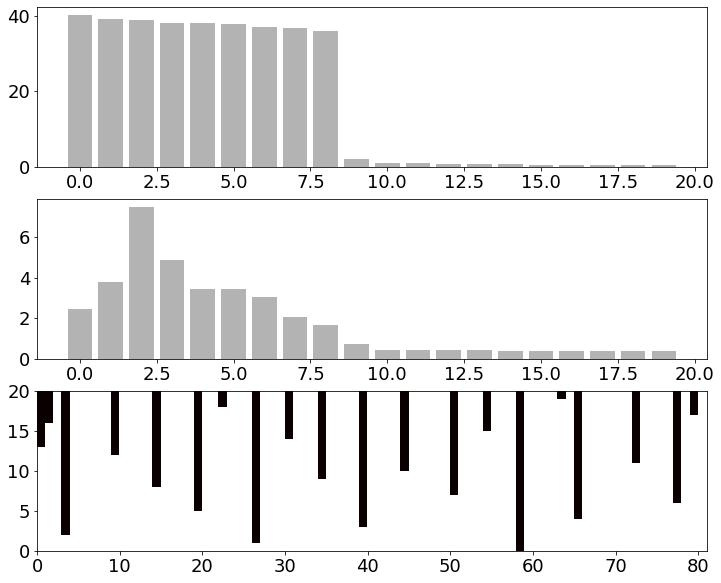

In [111]:
plt.rcParams['figure.figsize'] = [12,10]
fig, axs = plt.subplots(3,1)
axs[0].bar(range(n2),np.log(kond),facecolor=(0.7,0.7,0.7))
axs[1].bar(range(n2),np.log(E+1),facecolor=(0.7,0.7,0.7))
axs[2].pcolor(-Psum.T,cmap='hot')

plt.show()

In [112]:
titer = np.arange(1,21)
titer = np.append(titer,25)
titer2 = np.arange(9,21)
titer2 = np.append(titer2,25)
f1 = np.concatenate((f1,f.reshape(n,1)),axis=1)
f2 = np.concatenate((f1[:,9:21],f.reshape(n,1)),axis=1)


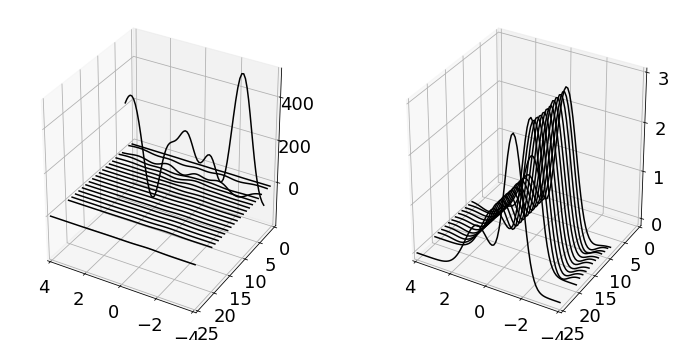

In [113]:
plt.rcParams['figure.figsize'] = [12,6]
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': '3d'})
for ti in range(len(titer)):
    axs[0].plot(x,titer[ti]*np.ones_like(x),f1[:,ti],color='k')
    
for ti in range(len(titer2)):
    axs[1].plot(x,titer2[ti]*np.ones_like(x),f2[:,ti],color='k')
    
for ax in axs:
    ax.view_init(azim=120,elev=30)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,25)


In [114]:
## Method 2 -- Max Diagonal vs. Off-Diagonal
n2 = 60 # number of sensors
nall = np.arange(n)
ns = np.array([],dtype='int')
kond2 = np.zeros(n2)
Psum2 = np.zeros((n,n2))
f2 = np.zeros((n,n2))
E2 = np.zeros(n2)
for jsense in range(n2):
    con = np.zeros(n-jsense-1)
    for jloop in range(n-jsense-1):
        P = np.zeros(n)
        P[ns] = 1
        P[nall[jloop]] = 1
        
        # compute M matrix
        M2 = np.zeros((10,10))
        for jj in range(10):
            for kk in range(jj+1):
                Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
                M2[jj,kk] = Area
                M2[kk,jj] = Area
                
        # compute proxy measure
        con[jloop] = 2*np.sum(np.diag(M2))-np.sum(M2.reshape(-1))
    n1 = np.argmax(con) # location to maximize condition #
    s1 = con[n1]
    kond2[jsense] = s1
    ns = np.append(ns,nall[n1]) # add sensor location
    nall = np.setdiff1d(nall,ns) # new sensor indices
    P = np.zeros(n)
    P[ns] = 1
    Psum2[:,jsense] = P
    M2 = np.zeros((10,10))
    for jj in range(10):
        for kk in range(jj+1):
            Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
            M2[jj,kk] = Area
            M2[kk,jj] = Area
            
    ftild = np.zeros(10)
    for jj in range(10): # reconstruction using gappy
        ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
    atild = np.linalg.solve(M2,ftild) # compute error
    f2[:,jsense] = yharm @ atild        # iterative reconstruction
    E2[jsense] = np.linalg.norm(f2[:,jsense]-f) # iterative error

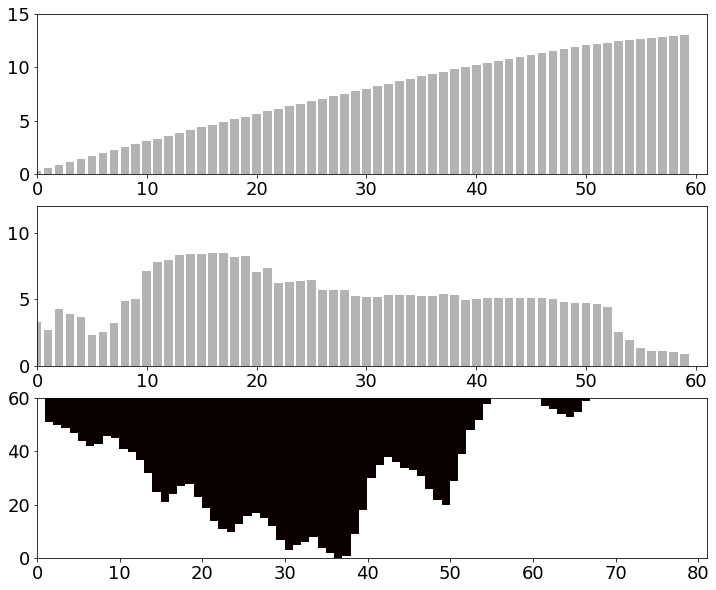

In [115]:
plt.rcParams['figure.figsize'] = [12,10]
fig, axs = plt.subplots(3,1)
axs[0].bar(range(n2),kond2,facecolor=(0.7,0.7,0.7))
axs[0].set_xlim(0,61)
axs[0].set_ylim(0,15)
axs[1].bar(range(n2),np.log(E2+1),facecolor=(0.7,0.7,0.7))
axs[1].set_xlim(0,61)
axs[1].set_ylim(0,12)
axs[2].pcolor(-Psum2.T,cmap='hot')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


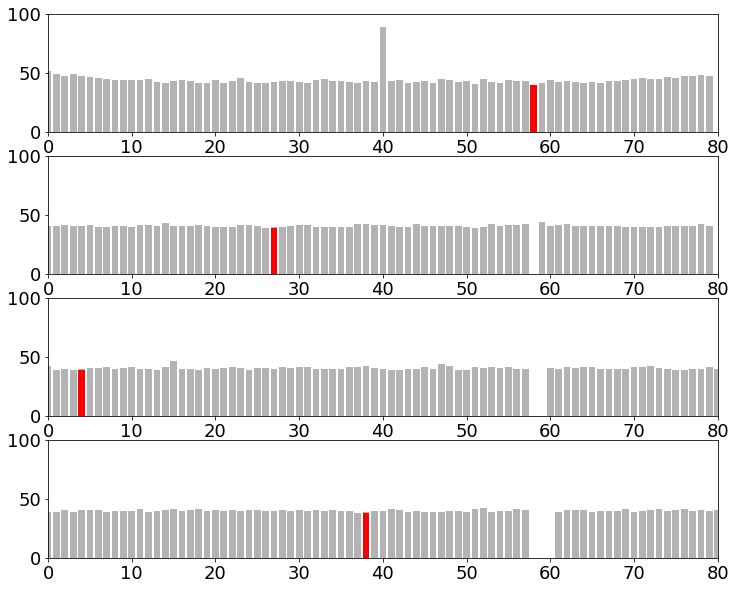

In [116]:
## Method 1 -- First 4 Condition Number
n2 = 4 # number of sensors
nall = np.arange(n)
ns = np.array([],dtype='int')
kond = np.zeros(n2)
Psum = np.zeros((n,n2))
f1 = np.zeros((n,n2))
E = np.zeros(n2)
fig,axs = plt.subplots(4,1)
for jsense in range(n2):
    con = np.zeros(n-jsense-1)
    for jloop in range(n-jsense-1):
        P = np.zeros(n)
        P[ns] = 1
        P[nall[jloop]] = 1
        
        # compute M matrix
        M2 = np.zeros((10,10))
        for jj in range(10):
            for kk in range(jj+1):
                Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
                M2[jj,kk] = Area
                M2[kk,jj] = Area
        
        con[jloop] = np.linalg.cond(M2) # compute condition number
    n1 = np.argmin(con) # location to minimize condition #
    s1 = con[n1]
    kond[jsense] = s1
    ns = np.append(ns,nall[n1]) # add sensor location
    nall = np.setdiff1d(nall,ns) # new sensor indices
    P = np.zeros(n)
    P[ns] = 1
    Psum[:,jsense] = P
    M2 = np.zeros((10,10))
    for jj in range(10):
        for kk in range(jj+1):
            Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
            M2[jj,kk] = Area
            M2[kk,jj] = Area
            
    ftild = np.zeros(10)
    for jj in range(10): # reconstruction using gappy
        ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
    atild = np.linalg.solve(M2,ftild) # compute error
    f1[:,jsense] = yharm @ atild        # iterative reconstruction
    E[jsense] = np.linalg.norm(f1[:,jsense]-f) # iterative error
    
    temp = np.zeros(n)
    if jsense == 0:
        contemp = con
        temp[n1] = s1
    elif jsense == 1:
        contemp = np.concatenate((con[:ns[0]],[0],con[ns[0]:]))
        con2 = contemp
        temp[n1+1] = s1
    elif jsense == 2:
        contemp = np.concatenate((con[:ns[0]],[0],con[ns[0]:ns[1]],[0],con[ns[1]:]))
        con3 = contemp
        temp[n1+1] = s1
    elif jsense == 3:
        contemp = np.concatenate((con[:ns[0]],[0],con[ns[0]:ns[1]],[0],con[ns[1]:ns[2]],[0],con[ns[2]:]))
        con4 = contemp
        temp[n1+1] = s1
        
    axs[jsense].bar(range(len(contemp)),np.log(contemp),facecolor=(0.7,0.7,0.7))
    axs[jsense].bar(range(len(temp)),np.log(temp),facecolor='r')
    axs[jsense].set_xlim(0,80)
    axs[jsense].set_ylim(0,100)